In [ ]:
!pip3 install gurobipy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import gurobipy as gp
from gurobipy import GRB

# Create an environment with your WLS license
params =
env = gp.Env(params=params)

file_path = ''

In [ ]:
import gurobipy as gp
from gurobipy import GRB

def solve_model(w, c, R, beta, N_RESTAURANTS, N_CUSTOMERS, tau, LAMBDA, MU_P, V_MAX = max(R, w / np.log(1/beta)), K, verbose = 0):

    model = gp.Model(env = env)
    model.setParam("NonConvex", 2)
    model.setParam('MIPGap', 1e-2)

    lam_f_rc = model.addMVar((N_RESTAURANTS, N_CUSTOMERS), lb = 0, ub = LAMBDA, vtype = GRB.CONTINUOUS, name = "lambda_f_rc")
    lam_p_rc = model.addMVar((N_RESTAURANTS, N_CUSTOMERS), lb = 0, ub = LAMBDA, vtype = GRB.CONTINUOUS, name = "lambda_p_rc")

    lam_f_cr = model.addMVar((N_CUSTOMERS, N_RESTAURANTS), lb = 0, ub = np.tile(np.sum(LAMBDA, axis = 0), (N_RESTAURANTS, 1)).T, vtype = GRB.CONTINUOUS, name = "lambda_f_cr")
    lam_p_cr = model.addMVar((N_CUSTOMERS, N_RESTAURANTS), lb = 0, ub = np.tile(np.sum(LAMBDA, axis = 0), (N_RESTAURANTS, 1)).T, vtype = GRB.CONTINUOUS, name = "lambda_p_cr")

    mu_p_in  = model.addMVar(N_RESTAURANTS, lb = 0, ub = MU_P, vtype = GRB.CONTINUOUS, name = "mu_p_in")
    mu_p_out = model.addMVar(N_CUSTOMERS,   lb = 0, ub = MU_P, vtype = GRB.CONTINUOUS, name = "mu_p_out")

    V_r = model.addMVar(N_RESTAURANTS, lb = R, ub = V_MAX, vtype = GRB.CONTINUOUS, name = "V_r")
    V_c = model.addMVar(N_CUSTOMERS,   lb = R, ub = V_MAX, vtype = GRB.CONTINUOUS, name = "V_c")

    V_bar = model.addVar(lb = R, ub = V_MAX, vtype = GRB.CONTINUOUS, name = "V_bar")

    T = model.addVar(lb = 0, ub = np.sum(2 * tau * LAMBDA * w), vtype = GRB.CONTINUOUS, name = "T")

    for i in range(N_RESTAURANTS):
        model.addConstr(V_bar >= V_r[i])
        model.addConstr(mu_p_in[i] * (V_bar - V_r[i]) == 0)
        model.addConstr(mu_p_in[i] + gp.quicksum(lam_p_cr[j, i] for j in range(N_CUSTOMERS)) == gp.quicksum(lam_p_rc[i, j] for j in range(N_CUSTOMERS)))
        model.addConstr(gp.quicksum(lam_f_cr[j, i] for j in range(N_CUSTOMERS)) == gp.quicksum(lam_f_rc[i, j] for j in range(N_CUSTOMERS)))

    for j in range(N_CUSTOMERS):
        model.addConstr(mu_p_out[j] * (V_c[j] - R) == 0)
        model.addConstr(gp.quicksum(lam_p_rc[i, j] for i in range(N_RESTAURANTS)) == gp.quicksum(lam_p_cr[j, i] for i in range(N_RESTAURANTS)) + mu_p_out[j])
        model.addConstr(gp.quicksum(lam_f_rc[i, j] for i in range(N_RESTAURANTS)) == gp.quicksum(lam_f_cr[j, i] for i in range(N_RESTAURANTS)))

    for j in range(N_CUSTOMERS):
      K = 3
      closest_restaurants = np.argsort(tau[:,j])[:K]
      for i in range(N_RESTAURANTS):
            model.addConstr(V_r[i] + c * tau[i, j] - beta ** tau[i, j] * V_c[j] >= 0)
            if LAMBDA[i,j] > 0:
              model.addConstr(lam_f_rc[i, j] + lam_p_rc[i, j] == LAMBDA[i, j])
            else:
              model.addConstr(lam_f_rc[i, j] == 0)
              model.addConstr(lam_p_rc[i, j] == 0)

            if i in closest_restaurants:
              model.addConstr(V_c[j] + c * tau[i, j] - beta ** tau[i, j] * V_r[i] >= 0)
              model.addConstr(lam_p_cr[j, i] * (V_c[j] + c * tau[i, j] - beta ** tau[i, j] * V_r[i]) == 0)
            else:
              model.addConstr(lam_p_cr[j, i] == 0)

    model.addConstr(MU_P >= gp.quicksum(mu_p_in[i] for i in range(N_RESTAURANTS)))
    model.addConstr(gp.quicksum(lam_p_rc[i, j] * (V_r[i] + c * tau[i, j] - beta ** tau[i, j] * V_c[j]) for i in range(N_RESTAURANTS) for j in range(N_CUSTOMERS)) == T)

    obj_func_1 = gp.quicksum(w * (lam_f_rc[i, j] + lam_f_cr[j, i]) * tau[i, j] for i in range(N_RESTAURANTS) for j in range(N_CUSTOMERS))
    obj_func_2 = T
    model.setObjective(obj_func_1 + obj_func_2, GRB.MINIMIZE)
    model.optimize()

    results = {
        "obj_val": model.ObjVal,
        "V_r": V_r.X,
        "V_c": V_c.X,
        "V_bar": V_bar.x,
        "mu_p_in": mu_p_in.X,
        "mu_p_out": mu_p_out.X,
        "lam_f_rc": lam_f_rc.X,
        "lam_p_rc": lam_p_rc.X,
        "lam_f_cr": lam_f_cr.X,
        "lam_p_cr": lam_p_cr.X,
        "T": T.x
    }

    return results

In [ ]:
import pandas as pd
import numpy as np
import random
import math
import sys

pd.set_option('display.max_columns', None)

def dist(lat1, lng1, lat2, lng2):
    return np.abs(lat1 - lat2) + np.abs(lng1 - lng2)

def get_grid_ids(lng, lat, grid_size):
    grid_x = math.floor(lng / grid_size)
    grid_y = math.floor(lat / grid_size)
    return grid_x, grid_y

In [ ]:
all_waybill = pd.read_csv(file_path)

all_waybill['sender_lat'] /= 1e6
all_waybill['sender_lng'] /= 1e6
all_waybill['recipient_lat'] /= 1e6
all_waybill['recipient_lng'] /= 1e6
all_waybill['grab_lat'] /= 1e6
all_waybill['grab_lng'] /= 1e6

all_waybill['sender_lat'] = 6371 * np.radians(all_waybill['sender_lat'])
all_waybill['sender_lng'] = 6371 * 0.767 *  np.radians(all_waybill['sender_lng'])
all_waybill['recipient_lat'] = 6371 * np.radians(all_waybill['recipient_lat'])
all_waybill['recipient_lng'] = 6371 * 0.767 * np.radians(all_waybill['recipient_lng'])
all_waybill['grab_lat'] = 6371 * np.radians(all_waybill['grab_lat'])
all_waybill['grab_lng'] = 6371 * 0.767 * np.radians(all_waybill['grab_lng'])
all_waybill['delivery_distance'] = dist(all_waybill['recipient_lat'], all_waybill['recipient_lng'], all_waybill['sender_lat'], all_waybill['sender_lng'])

all_waybill['order_push_time_f'] = pd.to_datetime(all_waybill['order_push_time_f'])
all_waybill['dispatch_time_f'] = pd.to_datetime(all_waybill['dispatch_time_f'])
all_waybill['arrive_time_f'] = pd.to_datetime(all_waybill['arrive_time_f'])

all_waybill = all_waybill[~all_waybill['da_id'].isin([6,18])]
all_waybill = all_waybill.sort_values(["courier_id", "dispatch_time"]).reset_index(drop=True)

courier_trajectory = all_waybill[["courier_id", "order_id", "grab_time", "fetch_time", "arrive_time"]].drop_duplicates(subset = ["courier_id", "order_id"])
courier_trajectory.columns = ["courier_id", "order_id", "time_accepted", "time_pickup", "time_arrive"]
courier_trajectory = pd.wide_to_long(courier_trajectory, ["time"], i=["courier_id", "order_id"], j="action", sep = "_", suffix = "\\D+").reset_index()
courier_trajectory = courier_trajectory[courier_trajectory["time"] > 0]
courier_trajectory = courier_trajectory.merge(all_waybill[["courier_id", "order_id", "grab_lng", "grab_lat", "sender_lng", "sender_lat", "recipient_lng", "recipient_lat", "da_id", "estimate_arrived_time", "estimate_meal_prepare_time"]].drop_duplicates(), on = ["courier_id", "order_id"], how = "inner")
courier_trajectory["courier_lng"] = courier_trajectory.apply(lambda x: x["grab_lng"] if x["action"] == "accepted" else x["sender_lng"] if x["action"] == "pickup" else x["recipient_lng"], axis = 1)
courier_trajectory["courier_lat"] = courier_trajectory.apply(lambda x: x["grab_lat"] if x["action"] == "accepted" else x["sender_lat"] if x["action"] == "pickup" else x["recipient_lat"], axis = 1)
courier_trajectory = courier_trajectory[["courier_id", "order_id", "action", "time", "courier_lng", "courier_lat", "da_id", "estimate_arrived_time", "estimate_meal_prepare_time"]]
courier_trajectory = courier_trajectory.sort_values(["courier_id", "time"])
courier_trajectory["time"] = pd.to_datetime(courier_trajectory["time"], unit = "s", utc = True).dt.tz_convert('Asia/Shanghai')

courier_trajectory['time_diff'] = courier_trajectory['time'].diff()
courier_trajectory['courier_diff'] = courier_trajectory['courier_id'].diff()
courier_trajectory['lng_diff'] = courier_trajectory['courier_lng'].diff()
courier_trajectory['lat_diff'] = courier_trajectory['courier_lat'].diff()
courier_trajectory['distance'] = courier_trajectory['lng_diff'].abs() + courier_trajectory['lat_diff'].abs()
courier_trajectory['speed'] = (courier_trajectory['distance'] / courier_trajectory['time_diff'].dt.total_seconds()) * 3600

all_poi = all_waybill[['poi_id','da_id','sender_lng','sender_lat']].drop_duplicates(subset = ['poi_id','da_id']).reset_index(drop=True)

part_time_da_ids = [0,1,2,4,5,9,12,13,22]
full_time_da_ids = [3,7,8,10,11,14,15,16,17,19,20,21]

common_poi_ids = set(all_poi[all_poi['da_id'].isin(part_time_da_ids)]['poi_id']).intersection(set(all_poi[all_poi['da_id'].isin(full_time_da_ids)]['poi_id']))
full_time_poi_ids = set(all_poi[all_poi['da_id'].isin(full_time_da_ids)]['poi_id']).difference(common_poi_ids)
part_time_poi_ids = set(all_poi[all_poi['da_id'].isin(part_time_da_ids)]['poi_id']).difference(common_poi_ids)

all_waybill['poi_type'] = all_waybill['poi_id'].apply(lambda x: 'common' if x in common_poi_ids else 'part_time' if x in part_time_poi_ids else 'full_time')

In [ ]:
from sklearn.cluster import KMeans

df_restaurants = all_waybill[["sender_lng", "sender_lat"]].drop_duplicates()
df_customers = all_waybill[["recipient_lng", "recipient_lat"]].drop_duplicates()

X_restaurants = np.array(df_restaurants[["sender_lng", "sender_lat"]])
X_customers = np.array(df_customers[["recipient_lng", "recipient_lat"]])

n_restaurant_clusters = 20
n_customer_clusters = 30

clustering = KMeans(n_clusters = n_restaurant_clusters)
df_restaurants["sender_cluster"] = clustering.fit_predict(X_restaurants)

clustering = KMeans(n_clusters = n_customer_clusters)
df_customers["recipient_cluster"] = clustering.fit_predict(X_customers)

all_waybill = all_waybill.merge(df_restaurants, on = ["sender_lng", "sender_lat"]).merge(df_customers, on = ["recipient_lng", "recipient_lat"])

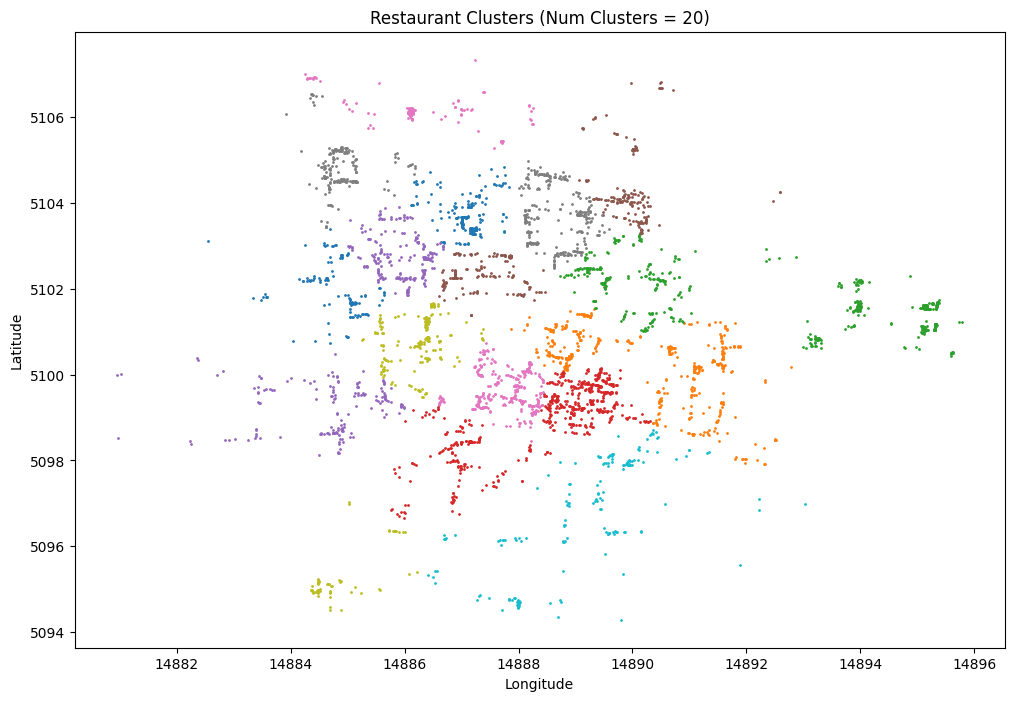

In [ ]:
import matplotlib.pyplot as plt

labels = np.array(df_restaurants["sender_cluster"])
plt.figure(figsize=(12, 8))
for cluster_id in range(n_restaurant_clusters):
    idx_lst = (labels == cluster_id)
    plt.scatter(X_restaurants[idx_lst, 0], X_restaurants[idx_lst, 1], label=f"Cluster {cluster_id}", s = 1)
plt.title(f"Restaurant Clusters (Num Clusters = {n_restaurant_clusters})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

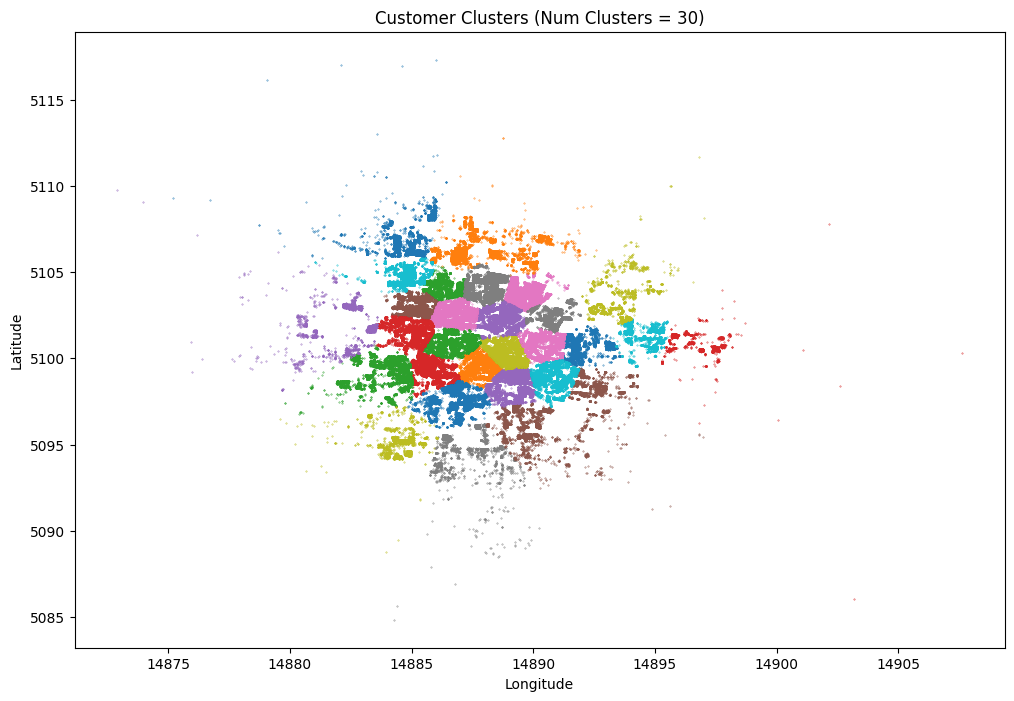

In [ ]:
labels = np.array(df_customers["recipient_cluster"])
plt.figure(figsize=(12, 8))
for cluster_id in range(n_customer_clusters):
    idx_lst = (labels == cluster_id)
    plt.scatter(X_customers[idx_lst, 0], X_customers[idx_lst, 1], label=f"Cluster {cluster_id}", s = 0.1)
plt.title(f"Customer Clusters (Num Clusters = {n_customer_clusters})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [ ]:
def compute_sender_recipient_distances(df):
    """
    Given dataframe with columns:
      'sender_lng', 'sender_lat', 'sender_cluster',
      'recipient_lng', 'recipient_lat', 'recipient_cluster'
    Returns a dataframe with pairwise distances between each sender cluster
    center and each recipient cluster center.
    """
    # Compute sender cluster centers
    sender_centers = (
        df[["sender_lng", "sender_lat", "sender_cluster"]]
        .drop_duplicates()
        .groupby("sender_cluster")[["sender_lng", "sender_lat"]]
        .mean()
        .rename(columns={"sender_lng": "lng", "sender_lat": "lat"})
    )

    # Compute recipient cluster centers
    recipient_centers = (
        df[["recipient_lng", "recipient_lat", "recipient_cluster"]]
        .drop_duplicates()
        .groupby("recipient_cluster")[["recipient_lng", "recipient_lat"]]
        .mean()
        .rename(columns={"recipient_lng": "lng", "recipient_lat": "lat"})
    )

    # Prepare empty matrix
    n_restaurants = sender_centers.shape[0]
    n_customers = recipient_centers.shape[0]
    tau = np.zeros((n_restaurants, n_customers))

    # Fill matrix
    for s_idx, (s_lng, s_lat) in sender_centers.iterrows():
        for r_idx, (r_lng, r_lat) in recipient_centers.iterrows():
            tau[s_idx, r_idx] = np.abs(s_lat - r_lat) + np.abs(s_lng - r_lng)

    return tau

In [ ]:
def calibrate_params(train_data, train_start_time, train_end_time):

  travel_speed = np.nanmean(courier_trajectory[(courier_trajectory['time'] >= train_start_time) & (courier_trajectory['time'] < train_end_time) & (courier_trajectory['courier_diff'] == 0) & (courier_trajectory['action'] == 'arrive')]['speed'])

  train_total_hours = (train_end_time - train_start_time).total_seconds() / 3600

  order_arrival = train_data.groupby(["sender_cluster", "recipient_cluster"]).size().reset_index(name='arrival_rate')
  order_arrival['arrival_rate'] /= train_total_hours
  # print(np.quantile(order_arrival["arrival_rate"], q = [0.25, 0.5, 0.75]))
  # order_arrival = order_arrival[order_arrival['arrival_rate'] >= 1]
  # lower_quant = np.quantile(order_arrival["arrival_rate"], q = 0.05)
  # print(lower_quant)
  # order_arrival = order_arrival[order_arrival['arrival_rate'] >= lower_quant]

  sender_clusters = order_arrival[["sender_cluster"]].drop_duplicates().reset_index(drop=True)
  recipient_clusters = order_arrival[["recipient_cluster"]].drop_duplicates().reset_index(drop=True)

  N_RESTAURANTS = len(train_data["sender_cluster"].unique())
  N_CUSTOMERS = len(train_data["recipient_cluster"].unique())

  tau = compute_sender_recipient_distances(train_data) / travel_speed

  LAMBDA = np.zeros((N_RESTAURANTS, N_CUSTOMERS))
  for i in range(sender_clusters.shape[0]):
    for j in range(recipient_clusters.shape[0]):
      sender_cluster = sender_clusters.iloc[i]['sender_cluster']
      recipient_cluster = recipient_clusters.iloc[j]['recipient_cluster']

      if len(order_arrival[(order_arrival['sender_cluster'] == sender_cluster)&(order_arrival['recipient_cluster'] == recipient_cluster)]) > 0:
        LAMBDA[i,j] = order_arrival[(order_arrival['sender_cluster'] == sender_cluster)&(order_arrival['recipient_cluster'] == recipient_cluster)]['arrival_rate'].values[0]

  MU_P = all_waybill[(all_waybill['order_push_time_f'] >= train_start_time) & (all_waybill['order_push_time_f'] < train_end_time) & (all_waybill['is_prebook'] == 0) & (all_waybill['da_id'].isin(part_time_da_ids))]['courier_id'].nunique() / train_total_hours

  return N_RESTAURANTS, N_CUSTOMERS, tau, LAMBDA, MU_P, order_arrival, sender_clusters, recipient_clusters

In [ ]:
date_range = pd.date_range(start='2022-10-18', end='2022-10-24')

start = "10:30"
end = "13:00"

for date in date_range:

  test_start_time = pd.to_datetime(f"{date.strftime('%Y-%m-%d')} {start} +0800")
  test_end_time = pd.to_datetime(f"{date.strftime('%Y-%m-%d')} {end} +0800")
  train_start_time = test_start_time - pd.Timedelta(days=1)
  train_end_time = test_start_time - pd.Timedelta(hours=1)

  test_data = all_waybill[(all_waybill['order_push_time_f'] >= test_start_time) & (all_waybill['order_push_time_f'] < test_end_time) & (all_waybill['is_prebook'] == 0) & (all_waybill['is_courier_grabbed'] == 1)].reset_index(drop = True)
  train_data = all_waybill[(all_waybill['order_push_time_f'] >= train_start_time) & (all_waybill['order_push_time_f'] < train_end_time) & (all_waybill['is_prebook'] == 0) & (all_waybill['is_courier_grabbed'] == 1)].reset_index(drop = True)

  N_RESTAURANTS, N_CUSTOMERS, tau, LAMBDA, MU_P, order_arrival, sender_clusters, recipient_clusters = calibrate_params(train_data, train_start_time, train_end_time)

  w = 33.6
  c = 3
  beta = 0.9

  R = 26.43 + 26.43 * beta + 26.43/2 * beta**2

  print(solve_model(w, c, R, beta, N_RESTAURANTS, N_CUSTOMERS, tau, LAMBDA, MU_P))

  break


Set parameter NonConvex to value 2
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
NonConvex  2

Academic license 2415008 - for non-commercial use only - registered to zz___@cornell.edu
Optimize a model with 2686 rows, 3102 columns and 9201 nonzeros
Model fingerprint: 0x088b910b
Model has 1251 quadratic constraints
Coefficient statistics:
  Matrix range     [8e-01, 1e+00]
  QMatrix range    [8e-01, 1e+00]
  QLMatrix range   [1e-02, 6e+01]
  Objective range  [2e-01, 6e+01]
  Bounds range     [4e-02, 8e+04]
  RHS range        [1e-02, 1e+02]
Presolve removed 840 rows and 838 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 1785 rows and 1784 columns
Presolve time: 0.02s
Presolved: 5950 rows, 2501 columns, 18533 nonzeros
Presolved model has 1212 bilinear

Experiment settings and runtime:
*   20 restaurant clusters, 30 customer clusters, k = 3: Optimal cost 18500.522058011255, runtime 3146 s (when filtering out orders with arrival_rates < 1)
*   Hard to obtain solution with larger $k$, not filtering out o-d pairs with small order arrivals, or choosing a large cluster size.
*   When $k$ is too small, it leads to infeasible solution
*   20 restaurant clusters, 30 customer clusters, restricting repositions only to restaurants that have orders to it: Optimal cost 18931.845302229165, runtime 1390 s (when filtering out orders with arrival_rates < 5% quantile)